## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression as LinReg
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import scipy.stats
import scipy.stats as st
from scipy.stats import ttest_1samp

In [2]:
gas = pd.read_csv('data/measurements.csv')

## Clean Data

In [3]:
def clean(x):

    #column names to lowercase
    lower = []
    for i in x.columns:
        lower.append(i.lower())
    x.columns = lower 

    #Puts underscore instead of spaces
    under_ = []
    for i in x.columns:
        if ' ' in i:
            under_.append(i.replace(' ', '_'))
        else:
            under_.append(i)
    x.columns = under_  
    
    def commas(y):
        y = y.replace(",",".", regex = True).astype(float)
        return(y)
    
    x['distance'] = commas(x['distance'])
    x['consume'] = commas(x['consume'])
    x['temp_outside'] = commas(x['temp_outside'])
    
    x['temp_inside'] = x['temp_inside'].replace(",",".", regex = True).astype(float)
    x['temp_inside'] = x['temp_inside'].fillna(round(x['temp_inside'].mean()))
    
    x['specials'] = x['specials'].fillna('U')
    
    price = []
    for i in x['gas_type']:
        if 'E10' in i:
            price.append(1.87)
        else:
            price.append(1.73)
    x['price'] = price
    
    x = x[['distance','consume','speed','temp_inside','temp_outside','specials','ac','rain','sun','gas_type', 'price']]
    
    return x
    

In [4]:
gassy = clean(gas) 

In [5]:
gassy

,distance,consume,speed,temp_inside,temp_outside,specials,ac,rain,sun,gas_type,price
0,28.0,5.0,26,21.5,12.0,U,0,0,0,E10,1.87
1,12.0,4.2,30,21.5,13.0,U,0,0,0,E10,1.87
2,11.2,5.5,38,21.5,15.0,U,0,0,0,E10,1.87
3,12.9,3.9,36,21.5,14.0,U,0,0,0,E10,1.87
4,18.5,4.5,46,21.5,15.0,U,0,0,0,E10,1.87
...,...,...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,39,24.5,18.0,U,0,0,0,SP98,1.73
384,16.1,4.3,38,25.0,31.0,AC,1,0,0,SP98,1.73
385,16.0,3.8,45,25.0,19.0,U,0,0,0,SP98,1.73
386,15.4,4.6,42,25.0,31.0,AC,1,0,0,SP98,1.73


### Visualisations

<AxesSubplot:ylabel='price'>

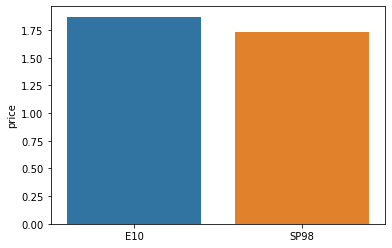

In [6]:
pr = gassy.groupby('gas_type')['price'].mean()

sns.barplot(data=gassy, x=gassy['gas_type'].unique(), y=pr)



**Here We Have the average price for each fuel. E10 is currently (18/08/2022) more expensive than SP98**

<AxesSubplot:ylabel='price'>

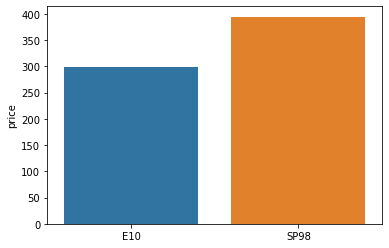

In [7]:
pr = gassy.groupby('gas_type')['price'].sum()

sns.barplot(data=gassy, x=gassy['gas_type'].unique(), y=pr)



**But the total spent on SP98 is more in total, at a difference of almost 100**

In [8]:
groupgas = gassy.groupby('gas_type')['consume'].count()

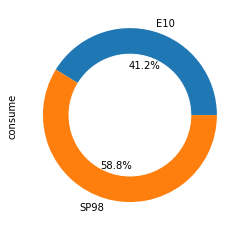

In [9]:
groupgas.plot.pie(autopct="%.1f%%")
my_circle=plt.Circle( (0,0), 0.7, color='white')
c=plt.gcf()
c.gca().add_artist(my_circle);

**The consumation of SP98 is higher than that of E10, which is to be expected, but the amount spent with regards to consumation is lower**

<AxesSubplot:ylabel='price'>

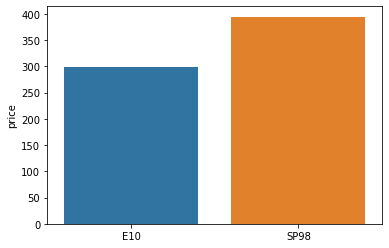

In [10]:
pr = gassy.groupby('gas_type')['price'].sum()

sns.barplot(data=gassy, x=gassy['gas_type'].unique(), y=pr)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='distance', ylabel='Density'>

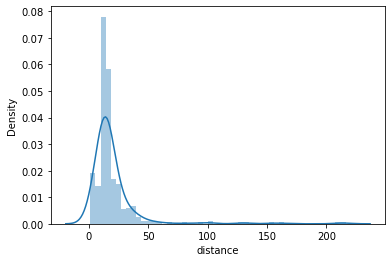

In [11]:
sns.distplot(gassy['distance'])

**The majority of the distances per journey averaged at beterrn 0 and 50 km**

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='speed', ylabel='Density'>

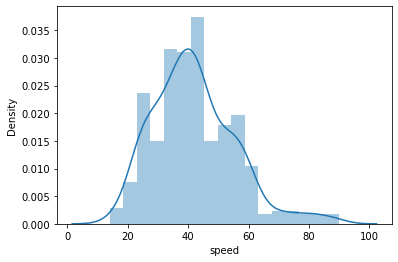

In [12]:
sns.distplot(gassy['speed'])

**while the speed rarely exceeded 60km/h**

## Machine Learning Prep

### Balance Data

Here we balance the datasets, to ensure that the data is fairly represented with E10, which was used less

In [13]:
gascl = gassy[['distance','consume','speed','temp_inside','temp_outside','specials','ac','rain','sun','gas_type']]

In [14]:
E10 = gascl[gascl['gas_type'] == 'E10']
E10 = E10.reset_index(drop = True)
SP98 = gascl[gascl['gas_type'] == 'SP98'][0:160]
SP98 = SP98.reset_index(drop = True)

In [15]:
gascl = pd.concat([E10,SP98]).reset_index(drop = True)

### Checking the Correlation between columns

check correlation to see if there is any danger of colinearity

In [16]:
gascl.corr()

,distance,consume,speed,temp_inside,temp_outside,ac,rain,sun
distance,1.000000,-0.179880,0.570302,0.158167,0.084046,-0.021997,-0.008529,0.041078
consume,-0.179880,1.000000,-0.246719,-0.091812,-0.261485,0.157544,0.235951,-0.156537
speed,0.570302,-0.246719,1.000000,0.096632,0.026812,-0.021826,0.020534,0.069715
temp_inside,0.158167,-0.091812,0.096632,1.000000,0.097619,0.103127,0.032150,0.210577
temp_outside,0.084046,-0.261485,0.026812,0.097619,1.000000,0.006249,-0.145762,0.316321
ac,-0.021997,0.157544,-0.021826,0.103127,0.006249,1.000000,0.385147,0.063119
rain,-0.008529,0.235951,0.020534,0.032150,-0.145762,0.385147,1.000000,-0.098758
sun,0.041078,-0.156537,0.069715,0.210577,0.316321,0.063119,-0.098758,1.000000


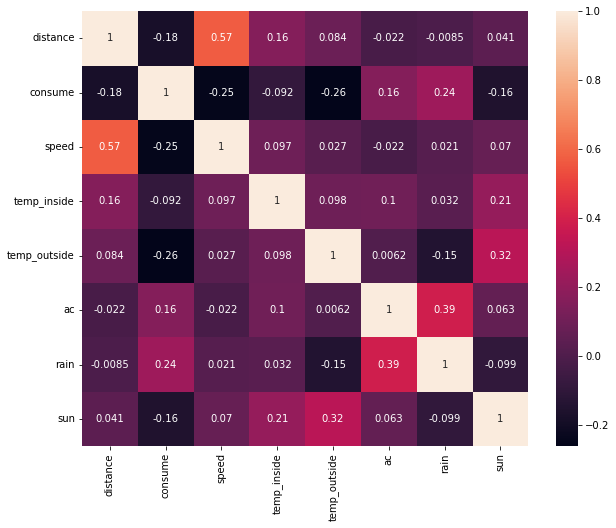

In [17]:
corr_matrix=gascl.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

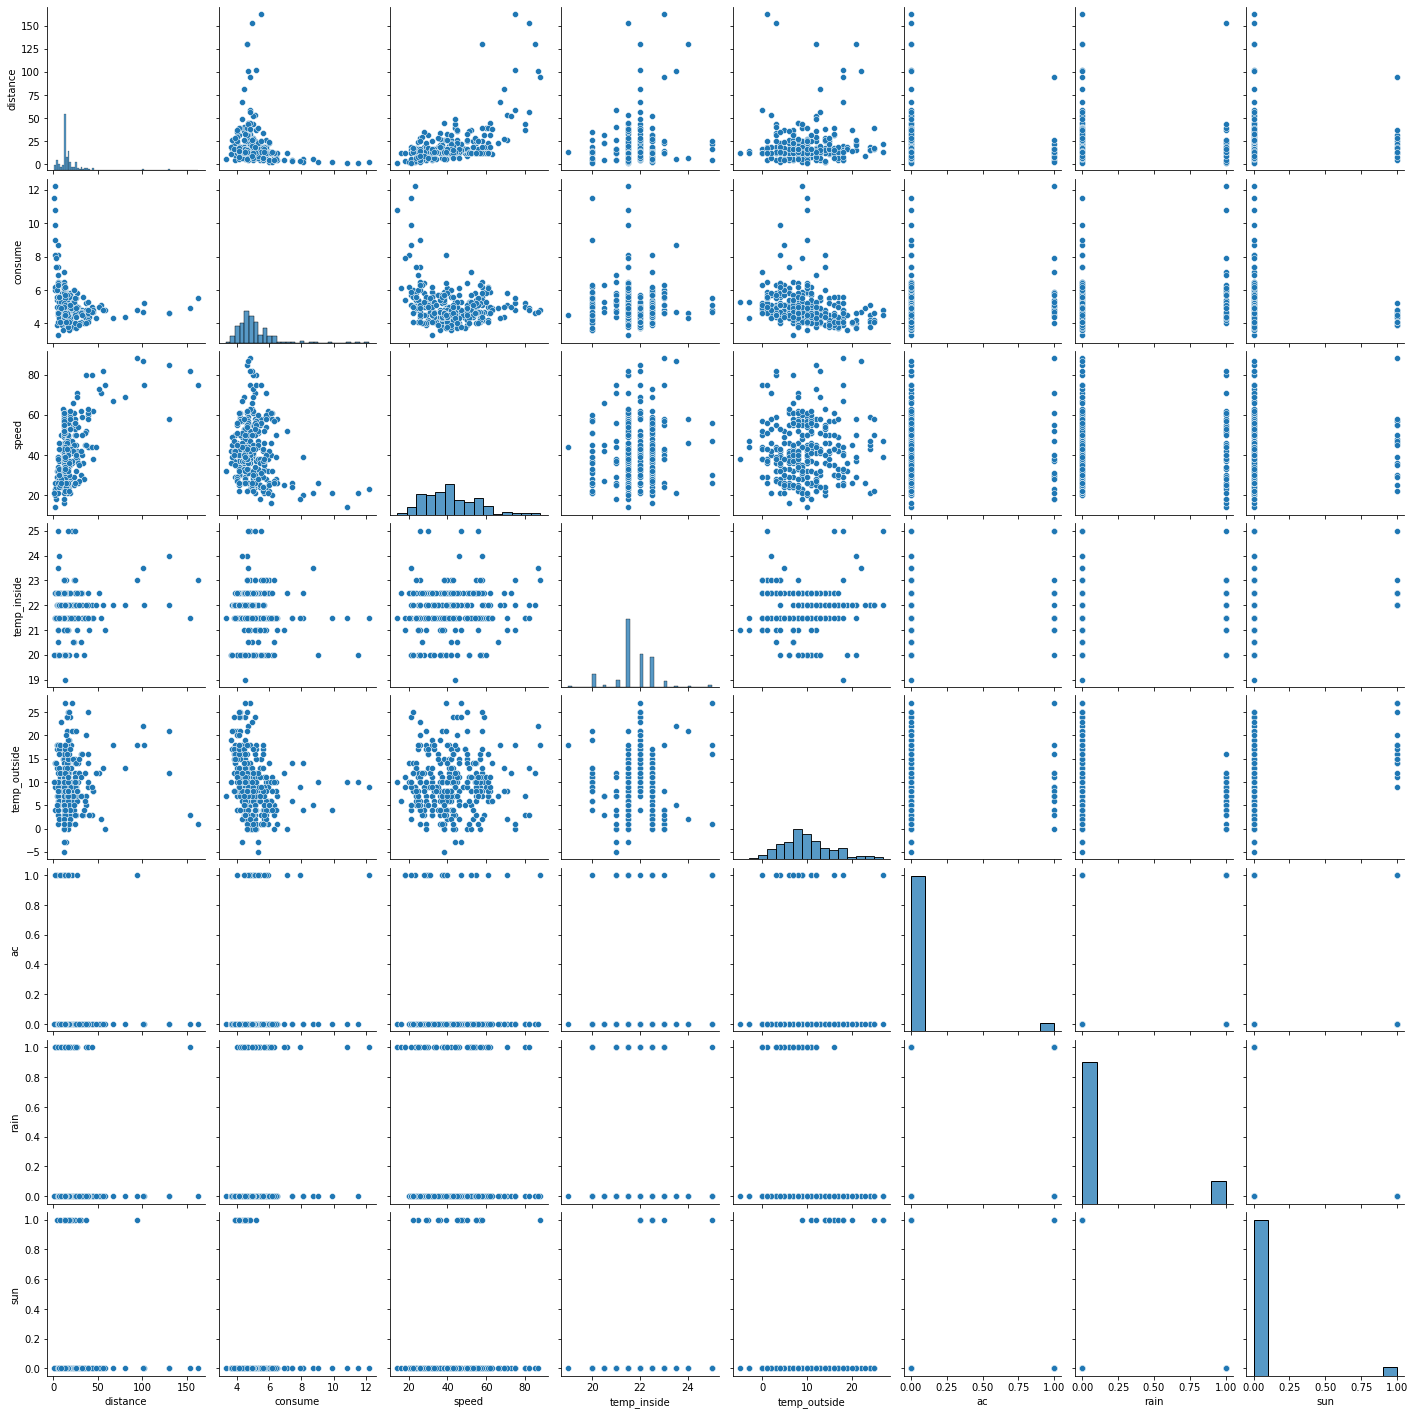

In [18]:
sns.pairplot(gascl)
plt.show()

## Machine Learning

In [19]:
X = gascl.drop(columns=['gas_type'])
y = gascl['gas_type']

In [20]:
y.value_counts()

E10     160
SP98    160
Name: gas_type, dtype: int64

In [21]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [22]:
##########Cat/Num Split##########

#Train
X_train_numerical = X_train.select_dtypes(include=np.number)
X_train_categorical = X_train.select_dtypes(include=np.object)


#Test
X_test_numerical = X_test.select_dtypes(include=np.number)
X_test_categorical = X_test.select_dtypes(include=np.object)

/var/folders/sm/8s2c1j894rq6v788yfhxt27r0000gn/T/ipykernel_12558/3347826989.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train_categorical = X_train.select_dtypes(include=np.object)
/var/folders/sm/8s2c1j894rq6v788yfhxt27r0000gn/T/ipykernel_12558/3347826989.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test_categorical = X_test.select_dtypes(include=np.object)


In [23]:
#numerical

#MinMax Transform Train

MinMaxtransformer = MinMaxScaler().fit(X_train_numerical)
x_train_normalized = MinMaxtransformer.transform(X_train_numerical)
x_train_normalized = pd.DataFrame(x_train_normalized,columns=X_train_numerical.columns)
X_num_train = x_train_normalized


#MinMax Transform Test
x_test_normalized = MinMaxtransformer.transform(X_test_numerical)
x_test_normalized = pd.DataFrame(x_test_normalized,columns=X_test_numerical.columns)
X_num_test = x_test_normalized

In [24]:
#Ordinally Encode Values
def ordenc(x):
    orden = []
    for i in x:
        if 'U' in i:
            orden.append(0)
        else:
            orden.append(1)
    x = orden
    return x
            
#Train
X_train_encoded = ordenc(X_train_categorical['specials'])
X_train_encoded = pd.DataFrame(X_train_encoded, columns = X_train_categorical.columns)

    
#Test
X_test_encoded = ordenc(X_test_categorical['specials'])
X_test_encoded = pd.DataFrame(X_test_encoded, columns = X_test_categorical.columns)

In [25]:
#Concat Train Values
X_num_train = X_num_train.reset_index(drop = True)
X_train_encoded = X_train_encoded.reset_index(drop = True)
X_train_scaled = pd.concat([X_num_train, X_train_encoded], axis = 1)
X_train_scaled

,distance,consume,speed,temp_inside,temp_outside,ac,rain,sun,specials
0,0.096583,0.060976,0.364865,0.500000,0.53125,0.0,0.0,0.0,0
1,0.078844,0.158537,0.256757,0.500000,0.71875,0.0,0.0,0.0,0
2,0.072930,0.158537,0.324324,0.666667,0.18750,0.0,1.0,0.0,1
3,0.035480,0.207317,0.216216,0.500000,0.68750,0.0,0.0,0.0,0
4,0.068988,0.219512,0.162162,0.666667,0.28125,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...
251,0.082786,0.219512,0.202703,0.416667,0.34375,0.0,0.0,0.0,0
252,0.099212,0.182927,0.472973,0.416667,0.31250,0.0,0.0,0.0,0
253,0.076873,0.317073,0.243243,0.583333,0.46875,0.0,0.0,0.0,0
254,0.007227,0.695122,0.162162,0.166667,0.46875,0.0,0.0,0.0,0


In [26]:
#Concat Test Values
X_num_test = X_num_test.reset_index(drop = True)
X_test_encoded = X_test_encoded.reset_index(drop = True)
X_test_scaled = pd.concat([X_num_test, X_test_encoded], axis = 1)
X_test_scaled

,distance,consume,speed,temp_inside,temp_outside,ac,rain,sun,specials
0,0.061104,0.195122,0.662162,0.416667,0.34375,0.0,0.0,0.0,0
1,0.195795,0.170732,0.378378,0.250000,0.37500,0.0,0.0,0.0,0
2,0.072930,0.097561,0.581081,0.416667,0.43750,0.0,0.0,0.0,0
3,0.133377,0.243902,0.405405,0.416667,0.43750,0.0,1.0,0.0,1
4,0.069645,0.243902,0.216216,0.416667,0.43750,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
59,0.155059,0.146341,0.527027,0.583333,0.59375,0.0,0.0,0.0,0
60,0.068988,0.317073,0.094595,0.166667,0.43750,1.0,1.0,0.0,1
61,0.096583,0.048780,0.418919,0.500000,0.68750,0.0,0.0,0.0,0
62,0.310775,0.121951,0.405405,0.500000,0.53125,0.0,0.0,0.0,0


### Logistic Regression

In [27]:
#Run a logistic regression 
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_scaled, y_train)

In [28]:
# The prediction:
predictions = classification.predict(X_test_scaled)
classification.score(X_test_scaled, y_test)

0.484375

### Decision Tree Classifier

In [29]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=4)

In [30]:
print("test data accuracy was ",model.score(X_test_scaled,y_test))
print("train data accuracy was ",model.score(X_train_scaled,y_train))

test data accuracy was  0.5
train data accuracy was  0.6953125


### Random forest

In [31]:
clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.2,
                             random_state = 42)
clf.fit(X_num_train, y_train)
print(clf.score(X_num_train, y_train))
print(clf.score(X_num_test, y_test))

0.57421875
0.5625


The Random Forest Classifier provides a better model an will predict unseen data very accurately when compared to the training data.

# Hypothesis : There is No difference Between E10 and SP98

In [32]:
display(E10.head(3))
display(SP98.head(3))

,distance,consume,speed,temp_inside,temp_outside,specials,ac,rain,sun,gas_type
0,28.0,5.0,26,21.5,12.0,U,0,0,0,E10
1,12.0,4.2,30,21.5,13.0,U,0,0,0,E10
2,11.2,5.5,38,21.5,15.0,U,0,0,0,E10


,distance,consume,speed,temp_inside,temp_outside,specials,ac,rain,sun,gas_type
0,5.4,3.3,32,21.5,7.0,U,0,0,0,SP98
1,2.0,9.9,21,21.5,4.0,U,0,0,0,SP98
2,14.2,5.1,32,21.5,7.0,U,0,0,0,SP98


In [33]:
confidence_level = 0.95
degrees_freedom = len(E10['consume']) - 1 
sample_mean = np.mean(E10['consume'])
sample_standard_error = scipy.stats.sem(E10['consume'])

confidence_interval_E10 = scipy.stats.t.interval(confidence_level, 
                                             degrees_freedom, 
                                             sample_mean, 
                                             sample_standard_error)

In [34]:
print('E10',confidence_interval_E10)

E10 (4.79057729018914, 5.071922709810862)


In [35]:
confidence_level = 0.95
degrees_freedom = len(~SP98['consume'].isna()) - 1 
sample_mean = np.mean(~SP98['consume'].isna())
sample_standard_error = scipy.stats.sem(SP98['consume'])

confidence_interval_SP98 = scipy.stats.t.interval(confidence_level, 
                                             degrees_freedom, 
                                             sample_mean, 
                                             sample_standard_error)

In [36]:
print("SP98",confidence_interval_SP98)

SP98 (0.8094769148170363, 1.1905230851829636)


The lower confidence interval for SP98

In [37]:
st.ttest_rel(E10['consume'], SP98['consume'])

Ttest_relResult(statistic=-1.5998682011320755, pvalue=0.11161296770781184)

**The H0 hypothesis must be rejected, as the pvalue is less than our confidence level of 5%. There is a difference between E10 and SP98**